#Spam Detection

In this part a LSTM model is constructed for identifying spam from non spam messages.

"SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [ ]:
i=0
for line in open('SMSSpamCollection'):
  print(line)
  i+=1
  if i>5:
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

ham	Ok lar... Joking wif u oni...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

ham	U dun say so early hor... U c already then say...

ham	Nah I don't think he goes to usf, he lives around here though

spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv



As it can be seen from the printed examples, the label value for spam messages is 'spam' while the label value for non-spam messages is 'ham'.


In [ ]:
num_spam=0
num_ham=0
for line in open('SMSSpamCollection'):
  if line[0]=='h':
    num_ham+=1
  elif line[0]=='s':
    num_spam+=1
print("num of spam messages",num_spam)
print("num of non-spam messages", num_ham)

num of spam messages 747
num of non-spam messages 4827


The package `torchtext` is used to load, process, and batch the data.

The goal is to build a **character level RNN**.


The dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

The dataset is split into `train`, `valid`, and `test`using a 60-20-20 split.

In [ ]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


In [ ]:
dataset[0].sms

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [ ]:
dataset[0].label

0

In [ ]:
train, test, valid = torchtext.legacy.data.Dataset.split(dataset, split_ratio=[0.6,0.2,0.2])

In [ ]:
print(len(train.examples),len(test.examples),len(valid.examples))

3343 1115 1114


There are many more non-spam messages than spam messages.
This **imbalance** in training data will be problematic for training. This disparity can be fixed by duplicating spam messages in the training set,
so that the training set is roughly balanced.


In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
len(train.examples)

5929

In [ ]:
text_field.build_vocab(train)

In [ ]:
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f2743065390>>,
            {' ': 2,
             '!': 44,
             '"': 77,
             '#': 79,
             '$': 87,
             '%': 92,
             '&': 64,
             "'": 60,
             '(': 76,
             ')': 72,
             '*': 74,
             '+': 75,
             ',': 46,
             '-': 63,
             '.': 16,
             '/': 61,
             '0': 14,
             '1': 23,
             '2': 26,
             '3': 41,
             '4': 37,
             '5': 32,
             '6': 43,
             '7': 38,
             '8': 28,
             '9': 49,
             ':': 65,
             ';': 73,
             '<': 86,
             '<pad>': 1,
             '<unk>': 0,
             '=': 81,
             '>': 85,
             '?': 59,
             '@': 82,
             'A': 42,
             'B': 57,
             'C': 34,
             'D': 54,
             'E': 30,
   

In [ ]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'r',
 'i',
 's',
 'l',
 'u',
 'h',
 '0',
 'd',
 '.',
 'm',
 'c',
 'y',
 'w',
 'p',
 'g',
 '1',
 'f',
 'b',
 '2',
 'T',
 '8',
 'k',
 'E',
 'v',
 '5',
 'S',
 'C',
 'O',
 'I',
 '4',
 '7',
 'N',
 'x',
 '3',
 'A',
 '6',
 '!',
 'R',
 ',',
 'W',
 'P',
 '9',
 'M',
 'U',
 'H',
 'L',
 'D',
 'F',
 'Y',
 'B',
 'G',
 '?',
 "'",
 '/',
 '£',
 '-',
 '&',
 ':',
 'X',
 'z',
 'V',
 'j',
 'K',
 'J',
 ')',
 ';',
 '*',
 '+',
 '(',
 '"',
 'q',
 '#',
 'Q',
 '=',
 '@',
 'Z',
 'ü',
 '>',
 '<',
 '$',
 'Ü',
 '\x92',
 '|',
 '‘',
 '%',
 '\x93',
 '¡',
 '…',
 '–',
 'ú',
 '’',
 '“',
 '_',
 '\x94',
 '~',
 '\x91',
 '\x96',
 '[',
 '\\',
 ']',
 '^',
 'è',
 '—',
 '┾',
 '〨',
 '鈥']

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
iter=0
for batch in train_iter:
  iter+=1
  print("Maximum length:",batch.sms[1][0].item())
  num_pad=0
  for i in range(32):
    num_pad+=batch.sms[1][0].item()-batch.sms[1][i].item()
  print("number of <pad> in the batch:",num_pad)
  if iter>9:
    break
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

Maximum length: 51
number of <pad> in the batch: 12
Maximum length: 40
number of <pad> in the batch: 30
Maximum length: 121
number of <pad> in the batch: 14
Maximum length: 93
number of <pad> in the batch: 80
Maximum length: 38
number of <pad> in the batch: 15
Maximum length: 152
number of <pad> in the batch: 19
Maximum length: 68
number of <pad> in the batch: 29
Maximum length: 55
number of <pad> in the batch: 30
Maximum length: 72
number of <pad> in the batch: 17
Maximum length: 160
number of <pad> in the batch: 17


In [ ]:
batch.sms

(tensor([[50,  6,  8,  ..., 21,  3,  8],
         [52,  6, 15,  ..., 15, 10, 16],
         [55,  8,  3,  ..., 26, 37, 26],
         ...,
         [52,  9,  2,  ..., 55, 53,  1],
         [58,  4,  5,  ..., 12, 44,  1],
         [51,  2, 18,  ...,  4,  7,  1]]),
 tensor([160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         160, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159,
         159, 159, 159, 159]))

## Model Building


In [ ]:
dim=len(text_field.vocab.stoi)
ident = torch.eye(dim)

In [ ]:
ident.shape

torch.Size([114, 114])

In [ ]:
text,label=batch.sms[0], batch.label

In [ ]:
emb=nn.Embedding.from_pretrained(ident)

In [ ]:
text_emb=emb(text)

In [ ]:
text_emb.shape

torch.Size([32, 160, 114])

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        #out = torch.cat([torch.max(out, dim=1)[0], 
                # torch.mean(out, dim=1)], dim=1)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

## Training 

In [ ]:
def iteration(batch_size):
    train_iter = torchtext.legacy.data.BucketIterator(train,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.sms), 
                                              sort_within_batch=True,        
                                              repeat=False)
    valid_iter = torchtext.legacy.data.BucketIterator(valid,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.sms), 
                                              sort_within_batch=True,        
                                              repeat=False)
    test_iter = torchtext.legacy.data.BucketIterator(test,
                                              batch_size=batch_size,
                                              sort_key=lambda x: len(x.sms), 
                                              sort_within_batch=True,        
                                              repeat=False) 
    return train_iter, valid_iter, test_iter           

In [ ]:
def get_accuracy(model, data_iter, train=False):
    correct, total = 0, 0 
    if train==True:
      iter=0
      for batch in data_iter:
          iter+=1
          if iter==len(data_iter)-1:
            break
          texts=batch.sms[0]
          labels=batch.label
          output = model(texts)
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += labels.shape[0]
    else:
      for batch in data_iter:
          texts=batch.sms[0]
          labels=batch.label
          output = model(texts)
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += labels.shape[0]
    return correct / total

In [ ]:
import matplotlib.pyplot as plt
def train_network(model, train_iter, valid_iter, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        iter=0
        for batch in train_iter:
            iter+=1
            if iter==len(train_iter)-1:
              break
            texts=batch.sms[0]
            labels=batch.label
            optimizer.zero_grad()
            pred = model(texts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
        train_losses.append(float(loss)) 
        epochs.append(epoch)    
        train_acc.append(get_accuracy(model, train_iter, train=True))
        valid_acc.append(get_accuracy(model, valid_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(train_losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    return model

In [ ]:
train_iter, valid_iter, test_iter = iteration(64)

Epoch 1; Loss 0.674003; Train Acc 0.490720; Val Acc 0.868043
Epoch 2; Loss 0.659235; Train Acc 0.912821; Val Acc 0.921903
Epoch 3; Loss 0.686383; Train Acc 0.694875; Val Acc 0.580790
Epoch 4; Loss 0.558211; Train Acc 0.742210; Val Acc 0.644524
Epoch 5; Loss 0.521481; Train Acc 0.877916; Val Acc 0.952424
Epoch 6; Loss 0.439954; Train Acc 0.948238; Val Acc 0.931777
Epoch 7; Loss 0.190425; Train Acc 0.918100; Val Acc 0.962298
Epoch 8; Loss 0.232400; Train Acc 0.947386; Val Acc 0.962298
Epoch 9; Loss 0.252133; Train Acc 0.951813; Val Acc 0.966786
Epoch 10; Loss 0.173353; Train Acc 0.923378; Val Acc 0.975763
Epoch 11; Loss 0.197444; Train Acc 0.954538; Val Acc 0.968582
Epoch 12; Loss 0.223249; Train Acc 0.956922; Val Acc 0.971275
Epoch 13; Loss 0.268997; Train Acc 0.936659; Val Acc 0.973070
Epoch 14; Loss 0.296904; Train Acc 0.959135; Val Acc 0.971275
Epoch 15; Loss 0.616009; Train Acc 0.948067; Val Acc 0.972172
Epoch 16; Loss 0.159988; Train Acc 0.948067; Val Acc 0.973968
Epoch 17; Loss 0.

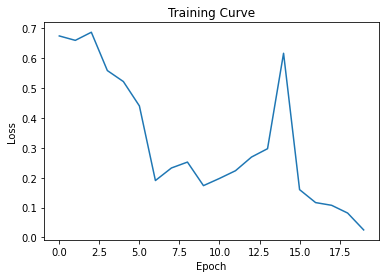

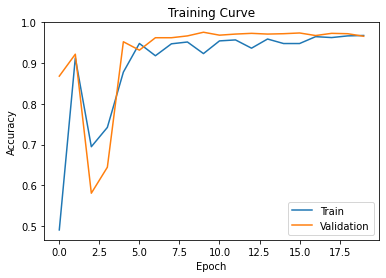

In [ ]:
model = RNN(dim, dim, 2)
gen=train_network(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

**4 Hyperparameters are tuned**:

1. RNN pooling: change the architecture of the model 
2. batch size: change the batch size using the function "iteration"
3. learning rate: change the lr using the function "train"
4. hidden size: change the model input


In [ ]:
def train_noplot(model, train_iter, valid_iter, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        iter=0
        for batch in train_iter:
            iter+=1
            if iter==len(train_iter)-1: #drop the last batch in training
              break
            texts=batch.sms[0]
            labels=batch.label
            optimizer.zero_grad()
            pred = model(texts)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            
        train_losses.append(float(loss)) 
        epochs.append(epoch)    
        train_acc.append(get_accuracy(model, train_iter, train=True))
        valid_acc.append(get_accuracy(model, valid_iter))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))
    return model

In [ ]:
# 1) different RNN pooling
class RNN_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_1, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

class RNN_2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN_2, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc0 = nn.Linear(hidden_size*2, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        # Pass the output of the last time step to the classifier
        out=self.fc0(out)
        out = self.fc(out)
        return out

In [ ]:
model = RNN_1(dim, dim, 2)
gen_rnn1=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.675220; Train Acc 0.642726; Val Acc 0.846499
Epoch 2; Loss 0.641867; Train Acc 0.764873; Val Acc 0.859964
Epoch 3; Loss 0.283975; Train Acc 0.899017; Val Acc 0.915619
Epoch 4; Loss 0.575987; Train Acc 0.814198; Val Acc 0.887792
Epoch 5; Loss 0.462022; Train Acc 0.890185; Val Acc 0.929084
Epoch 6; Loss 0.652760; Train Acc 0.862023; Val Acc 0.928187
Epoch 7; Loss 0.237814; Train Acc 0.923679; Val Acc 0.932675
Epoch 8; Loss 0.091394; Train Acc 0.928679; Val Acc 0.928187
Epoch 9; Loss 0.171895; Train Acc 0.936177; Val Acc 0.946140
Epoch 10; Loss 0.213174; Train Acc 0.760373; Val Acc 0.609515
Epoch 11; Loss 0.146437; Train Acc 0.935344; Val Acc 0.945242
Epoch 12; Loss 0.681016; Train Acc 0.778037; Val Acc 0.732496
Epoch 13; Loss 0.188455; Train Acc 0.899850; Val Acc 0.912926
Epoch 14; Loss 0.140153; Train Acc 0.942676; Val Acc 0.935368
Epoch 15; Loss 0.185759; Train Acc 0.946009; Val Acc 0.941652
Epoch 16; Loss 0.166201; Train Acc 0.952508; Val Acc 0.937163
Epoch 17; Loss 0.

In [ ]:
model = RNN_2(dim, dim, 2)
gen_rnn2=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.658914; Train Acc 0.516747; Val Acc 0.131957
Epoch 2; Loss 0.613340; Train Acc 0.528079; Val Acc 0.138241
Epoch 3; Loss 0.317871; Train Acc 0.918680; Val Acc 0.750449
Epoch 4; Loss 0.143859; Train Acc 0.938010; Val Acc 0.885996
Epoch 5; Loss 0.044259; Train Acc 0.931345; Val Acc 0.964991
Epoch 6; Loss 0.097761; Train Acc 0.941010; Val Acc 0.969479
Epoch 7; Loss 0.163677; Train Acc 0.955507; Val Acc 0.921903
Epoch 8; Loss 0.128375; Train Acc 0.962173; Val Acc 0.950628
Epoch 9; Loss 0.037313; Train Acc 0.961340; Val Acc 0.971275
Epoch 10; Loss 0.035962; Train Acc 0.965339; Val Acc 0.973070
Epoch 11; Loss 0.398931; Train Acc 0.959173; Val Acc 0.974865
Epoch 12; Loss 0.051336; Train Acc 0.968005; Val Acc 0.965889
Epoch 13; Loss 0.014500; Train Acc 0.971505; Val Acc 0.971275
Epoch 14; Loss 0.425235; Train Acc 0.969672; Val Acc 0.972172
Epoch 15; Loss 0.013740; Train Acc 0.968505; Val Acc 0.975763
Epoch 16; Loss 0.170380; Train Acc 0.972671; Val Acc 0.964991
Epoch 17; Loss 0.

It seems like concatenating the results of average and max pooling gets better train/validation accuracy.

In [ ]:
#2) batch size
train_iter1, valid_iter1, test_iter1 = iteration(128)

In [ ]:
model = RNN(dim, dim, 2)
gen_b1=train_noplot(model, train_iter1, valid_iter1, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.738223; Train Acc 0.483253; Val Acc 0.868043
Epoch 2; Loss 0.678864; Train Acc 0.926012; Val Acc 0.902154
Epoch 3; Loss 0.651966; Train Acc 0.918847; Val Acc 0.875224
Epoch 4; Loss 0.658931; Train Acc 0.936511; Val Acc 0.911131
Epoch 5; Loss 0.673667; Train Acc 0.838194; Val Acc 0.732496
Epoch 6; Loss 0.654074; Train Acc 0.943676; Val Acc 0.918312
Epoch 7; Loss 0.383301; Train Acc 0.939677; Val Acc 0.966786
Epoch 8; Loss 0.292201; Train Acc 0.952341; Val Acc 0.961400
Epoch 9; Loss 0.317923; Train Acc 0.947175; Val Acc 0.935368
Epoch 10; Loss 0.332357; Train Acc 0.950175; Val Acc 0.947038
Epoch 11; Loss 0.289319; Train Acc 0.928679; Val Acc 0.971275
Epoch 12; Loss 0.188054; Train Acc 0.934344; Val Acc 0.972172
Epoch 13; Loss 0.228824; Train Acc 0.931345; Val Acc 0.972172
Epoch 14; Loss 0.383058; Train Acc 0.925179; Val Acc 0.973070
Epoch 15; Loss 0.453868; Train Acc 0.949008; Val Acc 0.966786
Epoch 16; Loss 0.484067; Train Acc 0.924513; Val Acc 0.973070
Epoch 17; Loss 0.

In [ ]:
train_iter1, valid_iter1, test_iter1 = iteration(32)
model = RNN(dim, dim, 2)
gen_b2=train_noplot(model, train_iter1, valid_iter1, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.694022; Train Acc 0.581403; Val Acc 0.236984
Epoch 2; Loss 0.554829; Train Acc 0.945509; Val Acc 0.928187
Epoch 3; Loss 0.198220; Train Acc 0.939343; Val Acc 0.970377
Epoch 4; Loss 0.491467; Train Acc 0.925012; Val Acc 0.974865
Epoch 5; Loss 0.054804; Train Acc 0.957507; Val Acc 0.972172
Epoch 6; Loss 0.077855; Train Acc 0.961673; Val Acc 0.971275
Epoch 7; Loss 0.053136; Train Acc 0.966339; Val Acc 0.971275
Epoch 8; Loss 0.183088; Train Acc 0.967839; Val Acc 0.970377
Epoch 9; Loss 0.771092; Train Acc 0.969172; Val Acc 0.975763
Epoch 10; Loss 0.026595; Train Acc 0.969338; Val Acc 0.973968
Epoch 11; Loss 0.044618; Train Acc 0.940510; Val Acc 0.978456
Epoch 12; Loss 0.229966; Train Acc 0.960340; Val Acc 0.973968
Epoch 13; Loss 0.081730; Train Acc 0.970505; Val Acc 0.956912
Epoch 14; Loss 0.042509; Train Acc 0.974004; Val Acc 0.972172
Epoch 15; Loss 0.024999; Train Acc 0.972838; Val Acc 0.972172
Epoch 16; Loss 0.047989; Train Acc 0.977170; Val Acc 0.971275
Epoch 17; Loss 0.

Smaller batch size appears to work better and gets higher and more stable accuracy values

In [ ]:
#3) learning rate
model = RNN(dim, dim, 2)
gen_lr1=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-5)

Epoch 1; Loss 0.673082; Train Acc 0.482920; Val Acc 0.867145
Epoch 2; Loss 0.679465; Train Acc 0.482920; Val Acc 0.867145
Epoch 3; Loss 0.722879; Train Acc 0.482753; Val Acc 0.867145
Epoch 4; Loss 0.719012; Train Acc 0.481420; Val Acc 0.863555
Epoch 5; Loss 0.661249; Train Acc 0.479753; Val Acc 0.859964
Epoch 6; Loss 0.661648; Train Acc 0.478920; Val Acc 0.855476
Epoch 7; Loss 0.707870; Train Acc 0.480087; Val Acc 0.856373
Epoch 8; Loss 0.679864; Train Acc 0.589068; Val Acc 0.861759
Epoch 9; Loss 0.682123; Train Acc 0.766039; Val Acc 0.868043
Epoch 10; Loss 0.689946; Train Acc 0.807532; Val Acc 0.881508
Epoch 11; Loss 0.678662; Train Acc 0.872188; Val Acc 0.815978
Epoch 12; Loss 0.678848; Train Acc 0.871188; Val Acc 0.784560
Epoch 13; Loss 0.688238; Train Acc 0.815031; Val Acc 0.655296
Epoch 14; Loss 0.660393; Train Acc 0.838360; Val Acc 0.690305
Epoch 15; Loss 0.653519; Train Acc 0.735211; Val Acc 0.508977
Epoch 16; Loss 0.693239; Train Acc 0.774871; Val Acc 0.568223
Epoch 17; Loss 0.

In [ ]:
model = RNN(dim, dim, 2)
gen_lr2=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-3)

Epoch 1; Loss 0.370838; Train Acc 0.940677; Val Acc 0.970377
Epoch 2; Loss 0.211439; Train Acc 0.959840; Val Acc 0.972172
Epoch 3; Loss 0.020241; Train Acc 0.966339; Val Acc 0.972172
Epoch 4; Loss 0.031700; Train Acc 0.971005; Val Acc 0.974865
Epoch 5; Loss 0.064976; Train Acc 0.968505; Val Acc 0.974865
Epoch 6; Loss 0.159987; Train Acc 0.972838; Val Acc 0.977558
Epoch 7; Loss 0.386329; Train Acc 0.976504; Val Acc 0.973968
Epoch 8; Loss 0.021507; Train Acc 0.980503; Val Acc 0.965889
Epoch 9; Loss 0.136841; Train Acc 0.983503; Val Acc 0.979354
Epoch 10; Loss 0.043550; Train Acc 0.988669; Val Acc 0.981149
Epoch 11; Loss 0.020200; Train Acc 0.968339; Val Acc 0.983842
Epoch 12; Loss 0.048553; Train Acc 0.986336; Val Acc 0.972172
Epoch 13; Loss 0.055202; Train Acc 0.995667; Val Acc 0.984740
Epoch 14; Loss 0.031706; Train Acc 0.993834; Val Acc 0.974865
Epoch 15; Loss 0.010185; Train Acc 0.991668; Val Acc 0.983842
Epoch 16; Loss 0.011554; Train Acc 0.998667; Val Acc 0.982944
Epoch 17; Loss 0.

larger learning rate here gets higher train/validation accuracy and the model trains faster. 

In [ ]:
#4) hidden size
model = RNN(dim, dim*2, 2)
gen_hs1=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.614229; Train Acc 0.516747; Val Acc 0.131957
Epoch 2; Loss 0.723537; Train Acc 0.521080; Val Acc 0.139138
Epoch 3; Loss 0.383656; Train Acc 0.941843; Val Acc 0.920108
Epoch 4; Loss 0.057749; Train Acc 0.910515; Val Acc 0.833932
Epoch 5; Loss 0.275511; Train Acc 0.950842; Val Acc 0.933573
Epoch 6; Loss 0.200698; Train Acc 0.948175; Val Acc 0.970377
Epoch 7; Loss 0.288724; Train Acc 0.953008; Val Acc 0.972172
Epoch 8; Loss 0.153048; Train Acc 0.943843; Val Acc 0.974865
Epoch 9; Loss 0.121545; Train Acc 0.960673; Val Acc 0.972172
Epoch 10; Loss 0.129042; Train Acc 0.948342; Val Acc 0.923698
Epoch 11; Loss 0.232124; Train Acc 0.955341; Val Acc 0.973968
Epoch 12; Loss 0.087930; Train Acc 0.964839; Val Acc 0.973968
Epoch 13; Loss 0.166008; Train Acc 0.968672; Val Acc 0.972172
Epoch 14; Loss 0.068443; Train Acc 0.966506; Val Acc 0.972172
Epoch 15; Loss 0.036570; Train Acc 0.970505; Val Acc 0.968582
Epoch 16; Loss 0.114373; Train Acc 0.951175; Val Acc 0.974865
Epoch 17; Loss 0.

In [ ]:
model = RNN(dim, dim//2, 2)
gen_hs2=train_noplot(model, train_iter, valid_iter, num_epochs=20, learning_rate=1e-4)

Epoch 1; Loss 0.694886; Train Acc 0.483253; Val Acc 0.868043
Epoch 2; Loss 0.685017; Train Acc 0.664056; Val Acc 0.903950
Epoch 3; Loss 0.680298; Train Acc 0.910848; Val Acc 0.855476
Epoch 4; Loss 0.618735; Train Acc 0.933678; Val Acc 0.892280
Epoch 5; Loss 0.610229; Train Acc 0.934011; Val Acc 0.895871
Epoch 6; Loss 0.520918; Train Acc 0.947342; Val Acc 0.932675
Epoch 7; Loss 0.549317; Train Acc 0.939177; Val Acc 0.952424
Epoch 8; Loss 0.322925; Train Acc 0.939343; Val Acc 0.960503
Epoch 9; Loss 0.175663; Train Acc 0.940843; Val Acc 0.938959
Epoch 10; Loss 0.175606; Train Acc 0.940010; Val Acc 0.960503
Epoch 11; Loss 0.171324; Train Acc 0.943176; Val Acc 0.967684
Epoch 12; Loss 0.302143; Train Acc 0.947842; Val Acc 0.963196
Epoch 13; Loss 0.087722; Train Acc 0.923846; Val Acc 0.967684
Epoch 14; Loss 0.173891; Train Acc 0.947509; Val Acc 0.965889
Epoch 15; Loss 0.175904; Train Acc 0.949342; Val Acc 0.968582
Epoch 16; Loss 0.651224; Train Acc 0.836361; Val Acc 0.663375
Epoch 17; Loss 0.

It seems like with RNN_2 with the learning rate of 1e-3 and the batch size of 32, the model can yield the highest train/validation accuracy

Epoch 1; Loss 0.042095; Train Acc 0.949190; Val Acc 0.976661
Epoch 2; Loss 0.040733; Train Acc 0.975277; Val Acc 0.975763
Epoch 3; Loss 0.008887; Train Acc 0.993521; Val Acc 0.988330
Epoch 4; Loss 0.009195; Train Acc 0.998977; Val Acc 0.991023
Epoch 5; Loss 0.001248; Train Acc 0.999829; Val Acc 0.991023
Epoch 6; Loss 0.002970; Train Acc 1.000000; Val Acc 0.989228
Epoch 7; Loss 0.001441; Train Acc 1.000000; Val Acc 0.991921
Epoch 8; Loss 0.000254; Train Acc 1.000000; Val Acc 0.991023
Epoch 9; Loss 0.001958; Train Acc 1.000000; Val Acc 0.990126
Epoch 10; Loss 0.000029; Train Acc 1.000000; Val Acc 0.991023
Epoch 11; Loss 0.000144; Train Acc 1.000000; Val Acc 0.991023
Epoch 12; Loss 0.000384; Train Acc 1.000000; Val Acc 0.991023
Epoch 13; Loss 0.000004; Train Acc 1.000000; Val Acc 0.991023
Epoch 14; Loss 0.000012; Train Acc 1.000000; Val Acc 0.990126
Epoch 15; Loss 0.000126; Train Acc 1.000000; Val Acc 0.991023
Epoch 16; Loss 0.000147; Train Acc 1.000000; Val Acc 0.990126
Epoch 17; Loss 0.

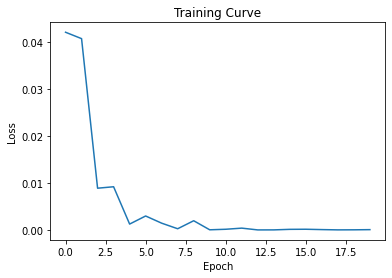

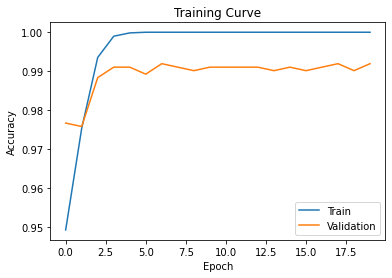

In [ ]:
model = RNN_2(dim, dim, 2)
train_iter1, valid_iter1, test_iter1 = iteration(32)
gen_best=train_network(model, train_iter1, valid_iter1, num_epochs=20, learning_rate=1e-3)


Before deploying a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. 

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
valid_spam_iter=torchtext.legacy.data.BucketIterator(valid_spam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)
valid_nospam_iter=torchtext.legacy.data.BucketIterator(valid_nospam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)

In [ ]:
1-get_accuracy(gen_best,valid_spam_iter) #false negative

0.05590062111801242

In [ ]:
1-get_accuracy(gen_best,valid_nospam_iter) #false positive

0.0031479538300105414

A false positive could result in user missing important texts, while a false negative could lead to the user being scammed, which comparably is worse than the former. Since when a text is falsely flagged as positive, the user can still check the message and recognize if it's actually a non-spam text.

## Evaluation

In [ ]:
#final test accuracy
get_accuracy(gen_best,test_iter1)

0.9910313901345291



Report the false positive rate and false negative rate of the model across the test set.

In [ ]:
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [ ]:
test_spam_iter=torchtext.legacy.data.BucketIterator(test_spam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)
test_nospam_iter=torchtext.legacy.data.BucketIterator(test_nospam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), 
                                        sort_within_batch=True,        
                                        repeat=False)

In [ ]:
1-get_accuracy(gen_best,test_spam_iter)#false negative

0.04516129032258065

In [ ]:
1-get_accuracy(gen_best,test_nospam_iter)#false positive

0.0031250000000000444

In [ ]:
#test on new message
msg = "machine learning is sooo cool!"

In [ ]:
id = [text_field.vocab.stoi[w]        # lookup the index of word
          for w in msg
          if w in text_field.vocab.stoi]

In [ ]:
correct, total = 0, 0
texts=torch.Tensor(id)
output = gen_best(texts.int().unsqueeze(0))
pred=output.max(1, keepdim=True)[1]

In [ ]:
F.softmax(output)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[9.9999e-01, 8.5149e-06]], grad_fn=<SoftmaxBackward0>)

As it can be seen, to be able to detect spam accurately, the model requires a lot of training. Therefore, the task of detecting spam is rather computationally expensive. But the results of extensive training is very good.

A simple baseline model should be a model that's easy to train and build, like random prediction algorithm. A random prediction model basically takes the unique classes in training set then randomly generates a class for each validation sample. Therefore, the input of such a model should be the classes (0 and 1) in training set, and the output is a list with the length of the number of samples in validation set.

# Transfer Learning

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.



In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2022-03-22 23:59:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   384KB/s    in 0.5s    

2022-03-22 23:59:26 (384 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: SMSSpamCollection       
  inflating: readme                  


In [ ]:
# set up data and verify
df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

In [ ]:
# create pretrained language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when a box or cell is broken up or is dropped
The problem usually starts when the local community is in a mental situation , and
The problem usually starts when the American Dad Out of Trouble
The problem usually starts when the three takes are only two or three hours of
The problem usually starts when the " Big Ten " is released .


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

In [ ]:
for i in range(5):
  print(lang_mod.predict("It was then that", n_words=10))

It was then that England and Wales were invited to the
It was then that Reg Taylor , the British Secretary
It was then that the UK 's first British Foreign
It was then that Ben Day , one of Ben
It was then that British Foreign Office e ' Wales


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.558297,3.817639,0.271429,00:06
1,4.823805,3.813969,0.271429,00:06
2,4.369751,3.771554,0.328571,00:06
3,4.049585,3.773782,0.285714,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.568745,3.766156,0.328571,00:05
1,3.541619,3.735488,0.328571,00:06
2,3.477848,3.701890,0.328571,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.381458,3.732709,0.328571,00:06
1,3.369162,3.730919,0.285714,00:06
2,3.357166,3.728911,0.285714,00:06


epoch,train_loss,valid_loss,accuracy,time
0,3.324349,3.744925,0.285714,00:08
1,3.287861,3.716099,0.271429,00:08
2,3.255067,3.717035,0.271429,00:08


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the xxunk and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos no , i * did n't * mean to post it . i wrote it , and like so many other times i 've xxunk stuff to you , i let it sit there . it xxup was what i was feeling at the time . i was angry . xxmaj before i left , i hit send , then stop . xxmaj it was n't there . i",ham
"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj margaret xxmaj hello "" xxmaj she is",ham
"xxbos xxmaj storming msg : xxmaj wen u lift d phne , u say "" xxup hello "" xxmaj do u knw wt is d real meaning of xxup hello ? ? . . . xxmaj it 's d name of a girl .. ! . . . xxmaj yes .. xxmaj and u knw who is dat girl ? ? "" xxmaj margaret xxmaj hello "" xxmaj she is",ham
"xxbos xxmaj and that is the problem . xxmaj you walk around in "" xxunk "" xxunk to what is going on around you . i say the same things constantly and they go in one xxunk and out the other while you go off doing whatever you want to do . xxmaj it 's not that you do n't know why i 'm upset -- it 's that you",ham


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3900 items)
x: TextList
xxbos i liked your new house,xxbos xxmaj xxunk i 'm walking in xxunk now ü faster come down ... xxmaj me very hungry ...,xxbos xxmaj wan2 win a meet+greet with xxmaj westlife 4 u or a m8 ? xxmaj they are currently on what tour ? 1)unbreakable , 2)untamed , 3)unkempt . xxmaj text 1,2 or 3 to 83049 . xxmaj cost 50p + std text,xxbos xxmaj otherwise had part time job na - tuition ..,xxbos xxmaj wait , do you know if xxunk in town ? i bet she does hella drugs !
y: CategoryList
ham,ham,spam,ham,ham
Path: .;

Valid: LabelList (1672 items)
x: TextList
xxbos xxmaj not a lot has happened here . xxmaj feels very xxunk . xxmaj xxunk is at her xxunk and xxunk is working lots . xxmaj just me and xxunk in at the mo . xxmaj how have you been ?,xxbos xxmaj the current xxunk bid is xxunk . xxmaj to xxunk this auction send xxup out . xxmaj customer xxmaj care : xxunk,xxbos xxmaj are you free xxunk i call now ?,xxbos xxmaj cold 

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 6.31E-02


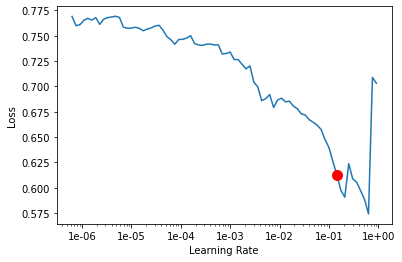

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.409516,0.083778,0.977273,00:08
1,0.196723,0.059730,0.985048,00:09
2,0.134856,0.074992,0.984450,00:09
3,0.103332,0.072663,0.985048,00:08
4,0.096041,0.076968,0.987440,00:09


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

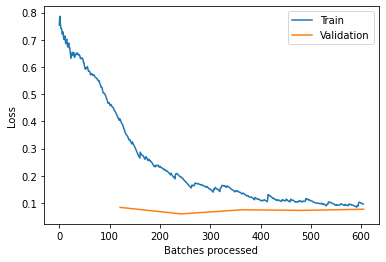

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 9.12E-08


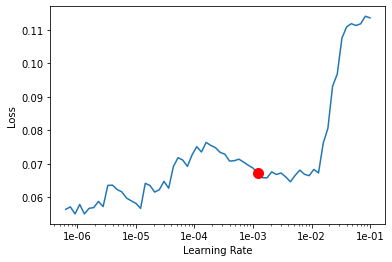

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.9491e-08]))

In [ ]:
# predict
learn_classifier.predict('Free entry call back now')

(Category tensor(0), tensor(0), tensor([0.5608, 0.4392]))

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1672, 2])

## Evaluate Performance

In [ ]:
valid_preds

tensor([[9.9989e-01, 1.0648e-04],
        [3.0712e-02, 9.6929e-01],
        [9.9985e-01, 1.5295e-04],
        ...,
        [1.9277e-02, 9.8072e-01],
        [1.0000e+00, 4.1672e-13],
        [3.1453e-01, 6.8547e-01]])

In [ ]:
valid_label

tensor([0, 1, 0,  ..., 1, 0, 1])

In [ ]:
correct, total = 0, 0
pred_2 = valid_preds.max(1, keepdim=True)[1]
correct += pred_2.eq(valid_label.view_as(pred_2)).sum().item()
total += valid_label.shape[0]
correct / total

0.9874401913875598

The validation accuracy obtained by ULMFit and the validation accuracy achieved by RNN in the first part are similar, but ULMFit takes shorter time to train, and is thus more efficient than regular RNN model.


A confusion matrix of the performance for the two models is provided. 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
preds_1=[]
valid_1=[]
txt=[]
for batch in valid_iter1:
    texts=batch.sms[0]
    labels=batch.label
    output_1 = gen_best(texts)
    text=[texts.tolist()[i] for i in range(len(texts))]
    txt.append(text)
    pred_1 = output_1.max(1, keepdim=True)[1]
    pred_01=[pred_1.tolist()[i][0] for i in range(len(pred_1))]
    preds_1.append(pred_01)
    valid_1.append(labels.tolist())

In [ ]:
flat_true= [item for sublist in valid_1 for item in sublist]
flat_pred = [item for sublist in preds_1 for item in sublist]
flat_txt = [item for sublist in txt for item in sublist]

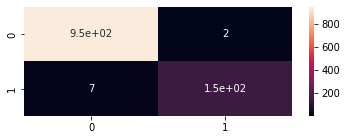

In [ ]:
#for RNN model in part 1
df_cm_1=pd.DataFrame(data=confusion_matrix(flat_true, flat_pred))
plt.figure(figsize = (6,2))
l = sns.heatmap(df_cm_1, annot=True)

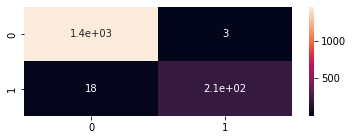

In [ ]:
#for ULMFit model
df_cm_2=pd.DataFrame(data=confusion_matrix(valid_label,pred_2))
plt.figure(figsize = (6,2))
l = sns.heatmap(df_cm_2, annot=True)

As it can be seen, the performance of the two models doesn't vary too much as the number of falsely categorized samples are both low. The outcome of the two models differs mainly on the false positive predictions - the ULMFit model doesn't have false positive predictions while the RNN model has both false positive and false negative predictions. 

In [ ]:
pt2_txt=np.array(df_val['text'])

In [ ]:
#print the false postive of model 1
for i in range(len(flat_true)):
  if flat_true[i]==0 and flat_pred[i]==1:
    print("".join([text_field.vocab.itos[w] for w in flat_txt[i]]))

Dunno da next show aft 6 is 850. Toa payoh got 650.
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May<pad><pad><pad>


In [ ]:
#print the false positive for model 2
for i in range(len(valid_label)):
  if valid_label[i]==0 and pred_2[i]==1:
    print(pt2_txt[i])

Honeybee Said: *I'm d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)
Send ur birthdate with month and year, I will tel u ur LIFE PARTNER'S name. and the method of calculation. Reply must.
Today is ACCEPT DAY..U Accept me as? Brother Sister Lover Dear1 Best1 Clos1 Lvblefrnd Jstfrnd Cutefrnd Lifpartnr Belovd Swtheart Bstfrnd No rply means enemy


In [ ]:
#print the false negative of model 1
for i in range(len(flat_true)):
  if flat_true[i]==1 and flat_pred[i]==0:
    print("".join([text_field.vocab.itos[w] for w in flat_txt[i]]))

RCT' THNQ Adrian for U text. Rgds Vatian<pad><pad><pad>
tddnewsletter@emc1.co.uk (More games from TheDailyDraw) Dear Helen, Dozens of Free Games - with great prizesWith..<pad><pad><pad><pad>
Hi this is Amy, we will be sending you a free phone number in a couple of days, which will give you an access to all the adult parties...<pad><pad><pad><pad><pad><pad>
Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, txt HORO followed by ur star sign, e. g. HORO ARIES<pad><pad><pad><pad><pad><pad>
Would you like to see my XXX pics they are so hot they were nearly banned in the uk!<pad><pad><pad><pad><pad>
Are you unique enough? Find out from 30th August. www.areyouunique.co.uk<pad>
This message is brought to you by GMW Ltd. and is not connected to the<pad><pad><pad>


In [ ]:
#print the false negative of model 2 
for i in range(len(valid_label)):
  if valid_label[i]==1 and pred_2[i]==0:
    print(pt2_txt[i])

Oh my god! I've found your number again! I'm so glad, text me back xafter this msgs cst std ntwk chg £1.50
Ur balance is now £600. Next question: Complete the landmark, Big, A. Bob, B. Barry or C. Ben ?. Text A, B or C to 83738. Good luck!
For the most sparkling shopping breaks from 45 per person; call 0121 2025050 or visit www.shortbreaks.org.uk
Twinks, bears, scallies, skins and jocks are calling now. Don't miss the weekend's fun. Call 08712466669 at 10p/min. 2 stop texts call 08712460324(nat rate)
accordingly. I repeat, just text the word ok on your mobile phone and send
New Tones This week include: 1)McFly-All Ab.., 2) Sara Jorge-Shock.. 3) Will Smith-Switch.. To order follow instructions on next message
For sale - arsenal dartboard. Good condition but no doubles or trebles!
Sorry I missed your call let's talk when you have the time. I'm on 07090201529
Are you unique enough? Find out from 30th August. www.areyouunique.co.uk
Missed call alert. These numbers called but left no messag

## Evaluate on New Data 

In [ ]:
learn_classifier.predict('machine learning is sooo cool!')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 9.2349e-19]))


Load 5 sample sentences from spam mail and test it out on the two models created.


In [ ]:
spam_mail=[]
ham_mail=[]
i=0
for k in range(100):
  if i ==5:
    break
  if dataset[k].label==0:
    ham_mail.append(dataset[k].sms)
    i+=1

In [ ]:
i=0
for k in range(100):
  if i ==5:
    break
  if dataset[k].label==1:
    spam_mail.append(dataset[k].sms)
    i+=1

In [ ]:
spam_mail

["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info']

In [ ]:
#model 1
for l in range(5):
  id_spam = [text_field.vocab.stoi[w]        # lookup the index of word
          for w in spam_mail[l]
          if w in text_field.vocab.stoi]
  texts_spam=torch.Tensor(id_spam)
  output_spam = gen_best(texts_spam.int().unsqueeze(0))
  pred_spam=output_spam.max(1, keepdim=True)[1]
  print(F.softmax(output_spam))

tensor([[1.2061e-09, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([[3.4508e-05, 9.9997e-01]], grad_fn=<SoftmaxBackward0>)
tensor([[6.3432e-07, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([[8.6598e-10, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([[2.5923e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:
#model 2
for m in range(5):
  print(learn_classifier.predict(spam_mail[m]))

(Category tensor(1), tensor(1), tensor([0.0064, 0.9936]))
(Category tensor(1), tensor(1), tensor([0.2549, 0.7451]))
(Category tensor(1), tensor(1), tensor([0.0244, 0.9756]))
(Category tensor(1), tensor(1), tensor([0.0030, 0.9970]))
(Category tensor(1), tensor(1), tensor([0.0086, 0.9914]))


As it can be seen both models identified spam mails correctly.


Load 5 sample sentences from  regular mail and test it out on the two models created. 

In [ ]:
ham_mail

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though",
 'Even my brother is not like to speak with me. They treat me like aids patent.']

In [ ]:
for l in range(5):
  id_ham = [text_field.vocab.stoi[w]        # lookup the index of word
          for w in ham_mail[l]
          if w in text_field.vocab.stoi]
  texts_ham=torch.Tensor(id_ham)
  output_ham = gen_best(texts_ham.int().unsqueeze(0))
  pred_ham=output_ham.max(1, keepdim=True)[1]
  print(F.softmax(output_ham))

tensor([[1.0000e+00, 4.1154e-06]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 8.9881e-11]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 1.1860e-10]], grad_fn=<SoftmaxBackward0>)
tensor([[1.0000e+00, 9.7360e-09]], grad_fn=<SoftmaxBackward0>)
tensor([[9.9997e-01, 2.7671e-05]], grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
#model 2
for m in range(5):
  print(learn_classifier.predict(ham_mail[m]))

(Category tensor(0), tensor(0), tensor([0.9971, 0.0029]))
(Category tensor(0), tensor(0), tensor([1.0000e+00, 1.2899e-14]))
(Category tensor(0), tensor(0), tensor([1.0000e+00, 9.6519e-24]))
(Category tensor(0), tensor(0), tensor([1.0000e+00, 8.0824e-13]))
(Category tensor(0), tensor(0), tensor([9.9981e-01, 1.8798e-04]))


As it can be seen, both models predicted the non-spam mails labels correctly. 